In [6]:
%matplotlib inline

In [7]:
import collections
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp_sparse
import tables
from matplotlib.mlab import PCA
import seaborn as sns
from collections import defaultdict
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from __future__ import division
from scipy.stats import linregress

In [8]:
np.random.seed(0)

GeneBCMatrix = collections.namedtuple('GeneBCMatrix', ['gene_ids', 'gene_names', 'barcodes', 'matrix'])

def get_matrix_from_h5(filename, genome):
    with tables.open_file(filename, 'r') as f:
        try:
            dsets = {}
            for node in f.walk_nodes('/' + genome, 'Array'):
                dsets[node.name] = node.read()
            matrix = sp_sparse.csc_matrix((dsets['data'], dsets['indices'], dsets['indptr']), shape=dsets['shape'])
            return GeneBCMatrix(dsets['genes'], dsets['gene_names'], dsets['barcodes'], matrix)
        except tables.NoSuchNodeError:
            raise Exception("Genome %s does not exist in this file." % genome)
        except KeyError:
            raise Exception("File is missing one or more required datasets.")
def Read10x(filepath):   
    with tables.open_file(filepath, 'r') as f:
        try:
            group = f.get_node(f.root)
        except tables.NoSuchNodeError:
            print "That genome does not exist in this file."
        gene_ids = getattr(group, 'gene_ids').read()
        gene_names = getattr(group, 'gene_names').read()
        gene = getattr(group, 'gene').read()
        umi_corrected_reads=getattr(group, 'umi_corrected_reads').read()
        nonconf_mapped_reads=getattr(group, 'nonconf_mapped_reads').read()
        conf_mapped_uniq_read_pos=getattr(group, 'conf_mapped_uniq_read_pos').read()
        unmapped_reads=getattr(group, 'unmapped_reads').read()
        barcodes = getattr(group, 'barcode').read()
        reads = getattr(group, 'reads').read()
        umi = getattr(group, 'umi').read()

        TABLE=pd.DataFrame()
        TABLE['bc']=barcodes
        TABLE['umi']=umi
        #TABLE['bcumi']=zip(barcodes,umi)
        TABLE['gene']=gene
        TABLE['unique']=[1]*len(TABLE)
        TABLE['map_logical']=conf_mapped_uniq_read_pos>0
        TABLE['read_counts']=reads+nonconf_mapped_reads+unmapped_reads
        return TABLE

def get_gene(BC,df_1):
    Total=df_1.gene[df_1.bc==BC].value_counts().to_frame()
    Total.columns=['Counts']
    genes1=np.zeros(32739)
    for index,rows in Total.iterrows():
        genes1[index]=rows['Counts']
    return genes1[:-1]
def setenv(newDict):
    DNA={}
    DNA['A']='00'
    DNA['C']='01'
    DNA['G']='10'
    DNA['T']='11'

    BC_DNA2={}
    for i in newDict.iterkeys(): 
        string=newDict[i]
        for j in DNA.iterkeys():
            string=string.replace(j,DNA[j])
        BC_DNA2[i]=int(string,2)
    return BC_DNA2

def hamming_distance(s1, s2):
    #Return the Hamming distance between equal-length sequences
    if len(s1) != len(s2):
        raise ValueError("Undefined for sequences of unequal length")
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))

In [49]:
newDict = {}
#insert path to barcode text file
with open('/../enriched_barcodes.txt', 'r') as f:
    for line in f:
        splitLine = line.split(',')
        newDict[int(splitLine[0])] = splitLine[1][:-1]
BC=setenv(newDict)

In [10]:
#CD_19, insert gene expression profile path
#filtered_matrix_h5='/.../filtered_gene_bc_matrices_h5.h5'

#HLA_DR, insert gene expression profile path
filtered_matrix_h5='/../filtered_gene_bc_matrices_h5.h5'

genome = "hg19"

#load expression profile
%time gene_bc_matrix = get_matrix_from_h5(filtered_matrix_h5, genome)

CPU times: user 117 ms, sys: 27 ms, total: 144 ms
Wall time: 155 ms


In [51]:
gnames=gene_bc_matrix.gene_names
cnames=gene_bc_matrix.barcodes
DGE=pd.DataFrame(gene_bc_matrix.matrix.toarray())
DGE.index=gnames
DGE.columns=cnames
cumi=DGE.sum()

In [52]:
#HLA-DR, load this one or the one below depending on which dataset is being analyzed

list_a=[4,5,6,7,8,9]
list_b=[12,13,14,15,16,17,30,31,32,33]
list_c=[34,35,36,37,38,39,40,41,42,43]
list_d=[44,45,46,47,48,49,50,51,52,53]
list_e=[54,55,56,57,58,59,60,61,62,63,64,65,66,67,68]

#All barcodes combined in one list
list_f=[4,5,6,7,8,9,12,13,14,15,16,17,30,31,32,33,34,35,37,38,39,40,41,42,43,44,45,46,48,49,50,51,52,53,54,55,56,58,59,60,61,62,63,64,65,68]

In [50]:
#CD-19

list_a=[1,2,3,4,5,6,8,9,10]
list_b=[11,12,13,14,15,16,17,18,19,20]
list_c=[21,22,23,24,25,26,27,28]
list_g3=[1,2,3,4,5,6,8,15,16,17,18,19,20,21,22,23,24,27,28]
list_f=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,27,28]

In [53]:
#load gene expression matrix (insert path)
enrich=pd.read_hdf('/Volumes/broad_blainey_lab_storage/Nav/temp/Manucript/Figures/FiguresV2/Data/Gene_expression/HLA_DR_Gene_expression_matrix.h5',key='10X').T
enrich2=enrich.copy()

#identify 10X barcode number, filter threshold, and barcode sequence
enrich2['bc']=[newDict[int(x.split('_')[0])]+'-1' for x in enrich2.index]
enrich2['filter']=[int(x.split('_')[2]) for x in enrich2.index]
enrich2['BC']=[int(x.split('_')[0]) for x in enrich2.index]

In [54]:
#Get pairwise correlations between all cells in the library

ham=defaultdict(int)
for item1 in enrich2[(enrich2['filter']==3)&(enrich2.BC.isin(list_f))].index:
    item1_1=enrich2.loc[item1]['bc']
    gene1=enrich.loc[item1]
    x=[]
    for item2 in cnames:
        gene2=DGE[item2]
        U2=linregress(np.log10(gene1+1),np.log10(gene2+1))
        x.extend([U2[2]**2])
    ham[item1_1]=x
corr_ham=pd.DataFrame.from_dict(ham)
corr_ham.index=[x[:-2] for x in cnames]

In [55]:
#identify the pairwise hamming distance of all cells in the library

ham3=defaultdict(int)
for item1 in enrich2[(enrich2['filter']==3)&(enrich2.BC.isin(list_f))]['bc']:
    item1_1=item1[-6:]
    x=[]
    for item2 in cnames:
        item2_1=item2[:-2][-6:]
        x.extend([hamming_distance(item1_1,item2_1)])
    ham3[item1]=x
ham3_df=pd.DataFrame.from_dict(ham3)
ham3_df.index=[x[:-2] for x in cnames]

In [56]:
#identify which cell barcodes represent on target amplification
col=pd.DataFrame(np.zeros(ham3_df.shape),columns=corr_ham.columns,index=corr_ham.index)
for item in list_f:
    barc=newDict[item]
    col.at[barc,barc+'-1']=1

In [57]:
X1=ham3_df[[newDict[x]+'-1' for x in list_f]].values

Y1=corr_ham[[newDict[x]+'-1' for x in list_f]].values
col2=col[[newDict[x]+'-1' for x in list_f]].values.astype('bool')

# for barcodes that are on target
Data=pd.concat([pd.DataFrame(X1[col2].flatten()).T,pd.DataFrame(Y1[col2].flatten()).T]).T
# for barcodes that are off target
Data=pd.concat([pd.DataFrame(X1[~col2].flatten()).T,pd.DataFrame(Y1[~col2].flatten()).T]).T

Data.columns=['Ham','Corr']


In [221]:
#Saving data to excel files
temp=Data[temp_cray.Ham==0]
temp['Corr'].to_clipboard()

In [3]:
#load correlation matrixes for enriched vs original and bootstrap enriched vs original
non_target=pd.read_csv('/Volumes/broad_blainey_lab_storage/Nav/temp/Manucript/Figures/FiguresV2/Data/Corr_ham/HLA_DR_corr_ham6.csv')
c_boot=pd.read_csv('/Volumes/broad_blainey_lab_storage/Nav/temp/Manucript/Figures/FiguresV2/Data/Bootstrap_controls/Bootstrapped_control_HLA_DR.csv')

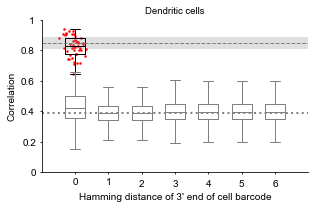

In [4]:
fig,ax=plt.subplots(figsize=(4.5,3))#3,2 4.5,3
sns.set(style='white')
sns.set_context("paper",rc={"lines.linewidth": 2,'axes.labelsize': 10,'text.fontsize': 10,'legend.fontsize': 10,
   'xtick.labelsize': 10,'ytick.labelsize': 10,'text.usetex': False})
positions=np.arange(7)/4
bp2=non_target.boxplot(column=['Target'],return_type='dict',positions=[0],widths=.15)

for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp2[element], color='k',linewidth=1)

bp=non_target.boxplot(column=[str(x) for x in range(7)],return_type='dict',positions=positions,widths=.15)

for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='gray',linewidth=1)


y = non_target['Target']
x = np.random.normal(0, 0.05, len(y))
ax.scatter(x,y,s=5,c='r')
    
plt.ylim([0,1.0])
plt.xlim([-.25,1.75])
plt.xlabel('')
plt.ylabel('Correlation')
plt.yticks([0,.2,.4,.6,.8,1],[0,.2,.4,.6,.8,1])
sns.despine()
ax.grid(False)
ax.tick_params(axis=u'both', which=u'both',length=2)
plt.minorticks_off()

plt.xlabel("Hamming distance of 3' end of cell barcode")
plt.title('Dendritic cells')
plt.ylabel('Correlation')


plt.tight_layout()

m=c_boot['mean'].mean()
s=c_boot['mean'].std()
plt.axhspan(m-2*s,m+2*s,facecolor='gray', alpha=0.25)
plt.axhline(m,color='gray',linewidth=1,linestyle='dashed')

plt.axhline(non_target['6'].mean(),color='gray',linewidth=2,linestyle='dotted')

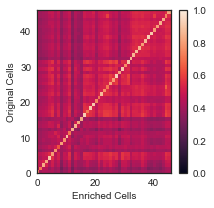

In [58]:
fig,ax=plt.subplots(figsize=(3,3))#2.5,2.5
pc=plt.pcolor(corr_ham[[newDict[x]+'-1' for x in list_f]].loc[[newDict[x] for x in list_f]],vmin=0,vmax=1)


sns.set_context("paper",rc={"lines.linewidth": 2,'axes.labelsize': 10,'text.fontsize': 20,'legend.fontsize': 10,
   'xtick.labelsize': 10,'ytick.labelsize': 10,'text.usetex': False})


plt.xlabel('Enriched Cells')
plt.ylabel('Original Cells')
plt.colorbar(pc)
